# Adding callbacks

now we're monitoring the performance of our model on the validation set, we're still having to fix the number of epochs that the model is training for ahead of time. What we would like to do is to have the ability to not only monitor the performance of the network, but also perform certain actions depending on those performance measures. That's where callbacks come in. Callbacks are an important type of object TensorFlow and Keras that are designed to be able to monitor the loss in metrics at certain points in the training run and perform some action that might depend on those loss in metric values. 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [2]:
class TrainingCallback(Callback):
    def on_train_begin(self, logs = None):
        print("Starting training")
        
    def on_epoch_begin(self, epoch, logs = None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs = None):
        print(f"Training : starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs = None):
        print(f"Training: finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs = None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs = None):
        print("finished training")

In [3]:
# constructing the testing callbacks

class TestingCallback(Callback):
    def on_test_begin(self, logs = None):
        print("Starting testing")
        
        
    def on_test_batch_begin(self, batch, logs = None):
        print(f"Testing : starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs = None):
        print(f"Testing: finished batch {batch}")
        
    def on_test_end(self, logs = None):
        print("finished testing")

In [4]:
# predicting callback

class PredictCallback(Callback):
    def on_predict_begin(self, logs = None):
        print("Starting predicting")
        
        
    def on_predict_batch_begin(self, batch, logs = None):
        print(f"predicting : starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs = None):
        print(f"predicting: finished batch {batch}")
        
    def on_predict_end(self, logs = None):
        print("finished predicting")

In [5]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [6]:
# Save the input and target variables
print(diabetes_dataset.keys())
data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [7]:
# Normalise the target data (this will make clearer training curves)

targets = (targets-targets.mean(axis = 0))/targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [8]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


# Define the learning rate schedule. The tuples below are (start_epoch, new_learning_rate)

In [9]:


lr_schedule = [
    (0, 0.006), (20, 0.004), (45, 0.002), (70, 0.001)
]

def get_new_epoch_lr(epoch, lr):
    # Checks to see if the input epoch is listed in the learning rate schedule 
    # and if so, returns index in lr_schedule
    epoch_in_sched = [i for i in range(len(lr_schedule)) if lr_schedule[i][0]==int(epoch)]
    if len(epoch_in_sched)>0:
        # If it is, return the learning rate corresponding to the epoch
        return lr_schedule[epoch_in_sched[0]][1]
    else:
        # Otherwise, return the existing learning rate
        return lr

In [10]:
# Define the custom callback

class LRScheduler(tf.keras.callbacks.Callback):
    
    def __init__(self, new_lr):
        super(LRScheduler, self).__init__()
        # Add the new learning rate function to our callback
        self.new_lr = new_lr

    def on_epoch_begin(self, epoch, logs=None):
        # Make sure that the optimizer we have chosen has a learning rate, and raise an error if not
        if not hasattr(self.model.optimizer, 'lr'):
              raise ValueError('Error: Optimizer does not have a learning rate.')
                
        # Get the current learning rate
        curr_rate = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        
        # Call the auxillary function to get the scheduled learning rate for the current epoch
        scheduled_rate = self.new_lr(epoch, curr_rate)

        # Set the learning rate to the scheduled learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_rate)
        print('Learning rate for epoch {} is {:7.3f}'.format(epoch, scheduled_rate))

In [11]:
# Print the model summary
# Build the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, BatchNormalization

def get_batchnormalized_model(wd, rate):
    model = Sequential()
    model.add(Dense(128, kernel_regularizer = regularizers.l2(wd), activation = 'relu', input_shape = (train_data.shape[1],)))
    BatchNormalization()
    Dropout(rate)
    model.add(Dense(128, kernel_regularizer = regularizers.l2(wd), activation = 'relu'))
    BatchNormalization()
    Dropout(rate)
    model.add(Dense(128, kernel_regularizer = regularizers.l2(wd), activation = 'relu'))
    BatchNormalization()
    Dropout(rate)
    model.add(Dense(128, kernel_regularizer = regularizers.l2(wd), activation = 'relu'))
    BatchNormalization()
    Dropout(rate)
    model.add(Dense(128, kernel_regularizer = regularizers.l2(wd), activation = 'relu'))
    BatchNormalization()
    Dropout(rate)
    model.add(Dense(128, kernel_regularizer = regularizers.l2(wd), activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

model2 = get_batchnormalized_model(0.001, 0.3)


model2.summary()

W0615 13:01:32.464303 139756527216448 deprecation.py:506] From /home/lokesh/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [12]:
model2.compile(optimizer = 'adam', loss = 'mse')

# Implementing the early stopping

In [13]:
# history2 = model2.fit(train_data, train_targets, epochs = 100,
#                      validation_split = 0.25, batch_size = 64, verbose = 2, callbacks = [LRScheduler(get_new_epoch_lr)])

In [14]:
history2 = model2.fit(train_data, train_targets, epochs = 100,
                     validation_split = 0.25, batch_size = 64, verbose = 2, callbacks = [LRScheduler(get_new_epoch_lr),tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1, mode = 'min')])

Train on 297 samples, validate on 100 samples
Learning rate for epoch 0 is   0.006
Epoch 1/100
297/297 - 0s - loss: 1.7456 - val_loss: 1.4695
Learning rate for epoch 1 is   0.006
Epoch 2/100
297/297 - 0s - loss: 1.2938 - val_loss: 1.3444
Learning rate for epoch 2 is   0.006
Epoch 3/100
297/297 - 0s - loss: 1.1590 - val_loss: 1.2468
Learning rate for epoch 3 is   0.006
Epoch 4/100
297/297 - 0s - loss: 1.0801 - val_loss: 1.1956
Learning rate for epoch 4 is   0.006
Epoch 5/100
297/297 - 0s - loss: 1.0402 - val_loss: 1.1712
Learning rate for epoch 5 is   0.006
Epoch 6/100
297/297 - 0s - loss: 1.0213 - val_loss: 1.1591
Learning rate for epoch 6 is   0.006
Epoch 7/100
297/297 - 0s - loss: 1.0112 - val_loss: 1.1498
Learning rate for epoch 7 is   0.006
Epoch 8/100
297/297 - 0s - loss: 1.0033 - val_loss: 1.1359
Learning rate for epoch 8 is   0.006
Epoch 9/100
297/297 - 0s - loss: 1.0041 - val_loss: 1.1290
Learning rate for epoch 9 is   0.006
Epoch 10/100
297/297 - 0s - loss: 0.9972 - val_loss: 

In [15]:
model2.evaluate(test_data, test_targets, verbose = False, callbacks = [TestingCallback()])

Starting testing
Testing : starting batch 0
Testing: finished batch 0
Testing : starting batch 1
Testing: finished batch 1
finished testing


0.8489999744627211

In [16]:
model2.predict(test_data, verbose = False, callbacks = [PredictCallback()])

Starting predicting
predicting : starting batch 0
predicting: finished batch 0
predicting : starting batch 1
predicting: finished batch 1
finished predicting


array([[0.00175124],
       [0.00141069],
       [0.00101504],
       [0.00142652],
       [0.00226361],
       [0.00161079],
       [0.00138497],
       [0.00216535],
       [0.00129563],
       [0.00113243],
       [0.00136808],
       [0.00169307],
       [0.00105694],
       [0.00125104],
       [0.00168246],
       [0.00142175],
       [0.00194368],
       [0.00143149],
       [0.00113773],
       [0.00129515],
       [0.00178188],
       [0.00124606],
       [0.00142351],
       [0.00154951],
       [0.00171372],
       [0.00214124],
       [0.00160161],
       [0.00151488],
       [0.00146654],
       [0.00146106],
       [0.00215644],
       [0.00143322],
       [0.00200105],
       [0.00109518],
       [0.00146356],
       [0.0015837 ],
       [0.00164139],
       [0.0010972 ],
       [0.00199693],
       [0.00195739],
       [0.00148374],
       [0.00156751],
       [0.00197238],
       [0.00214368],
       [0.00312721]], dtype=float32)

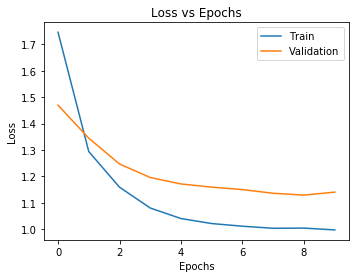

In [17]:
# Plot the learning curves

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

frame = pd.DataFrame(history2.history)
epochs = np.arange(len(frame))

fig = plt.figure(figsize=(12,4))

# Loss plot
ax = fig.add_subplot(121)
ax.plot(epochs, frame['loss'], label="Train")
ax.plot(epochs, frame['val_loss'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()


# more convieient way for adding learning rate scheduler

In [18]:
# def lr_function(epoch, lr):
#     if epoch % 2 == 0:
#         return lr
#     else:
#         return lr + epoch/1000

In [ ]:
# Train the model

# history = model.fit(train_data, train_targets, epochs=10,
#                     callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_function, verbose=1)], verbose=False)